In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import os
import re

In [3]:
FRAME_PER_SECOND = 60
COLOR='black'

calibrations = pd.read_csv('calibracion_cinematica.csv')

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 33
rcParams['xtick.labelsize'] = 33
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7.33Hz','7.66Hz','8Hz','9Hz','10Hz']
VOLT_ARRAY = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

FREQ_ARRAY_VALUES = [2,3,4,5,6,7,7.33,7.66,8,9,10]
VOLT_ARRAY_VALUES = [0.5,1,1.5,2,2.5]

#Creating the colormap
norm_v = plt.Normalize(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(FREQ_ARRAY_VALUES[0],FREQ_ARRAY_VALUES[-1])
cmap_f = plt.colormaps.get_cmap('viridis')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

In [4]:
# rcParams de mas_graficos.ipynb

PX_PER_MM = 7.532343134764206
FRAME_PER_SECOND = 60

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

# Gráficos para la cabeza

In [4]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/cabeza') if '.csv' in filepath])
filenamelist = pd.DataFrame().assign(name = csv_names)

## x(t), y(t)

### Agrupación por frecuencia

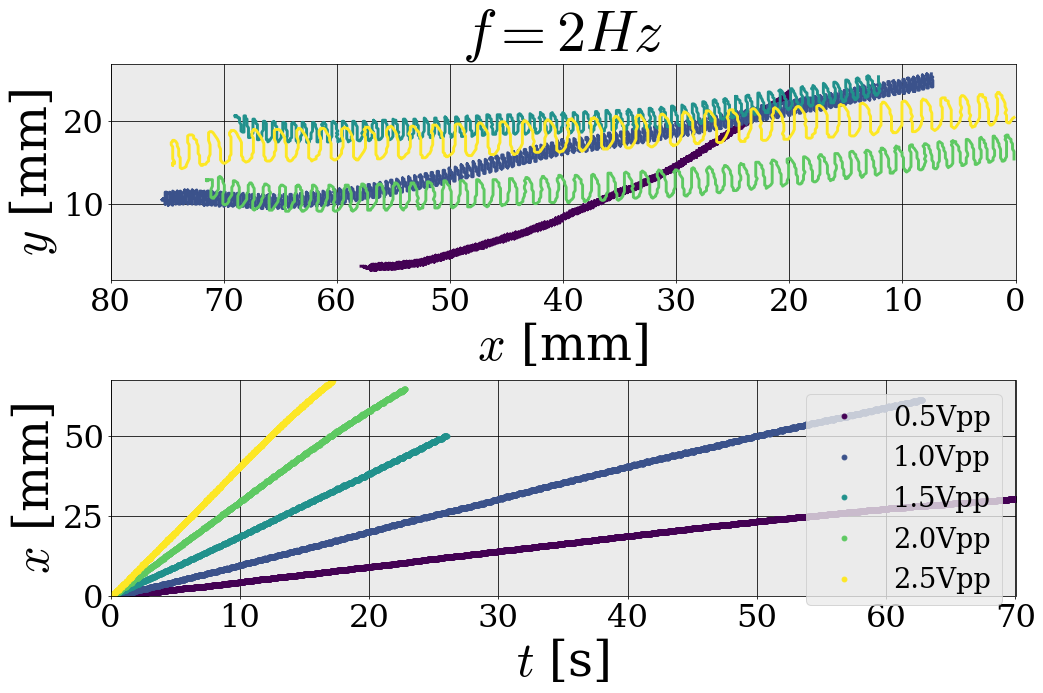

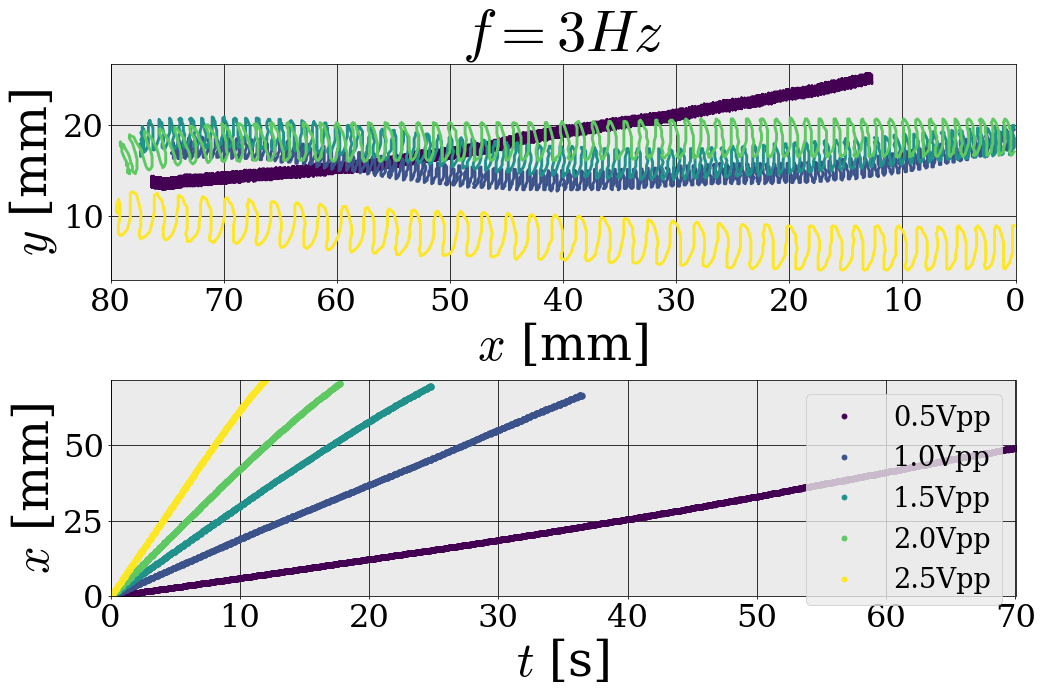

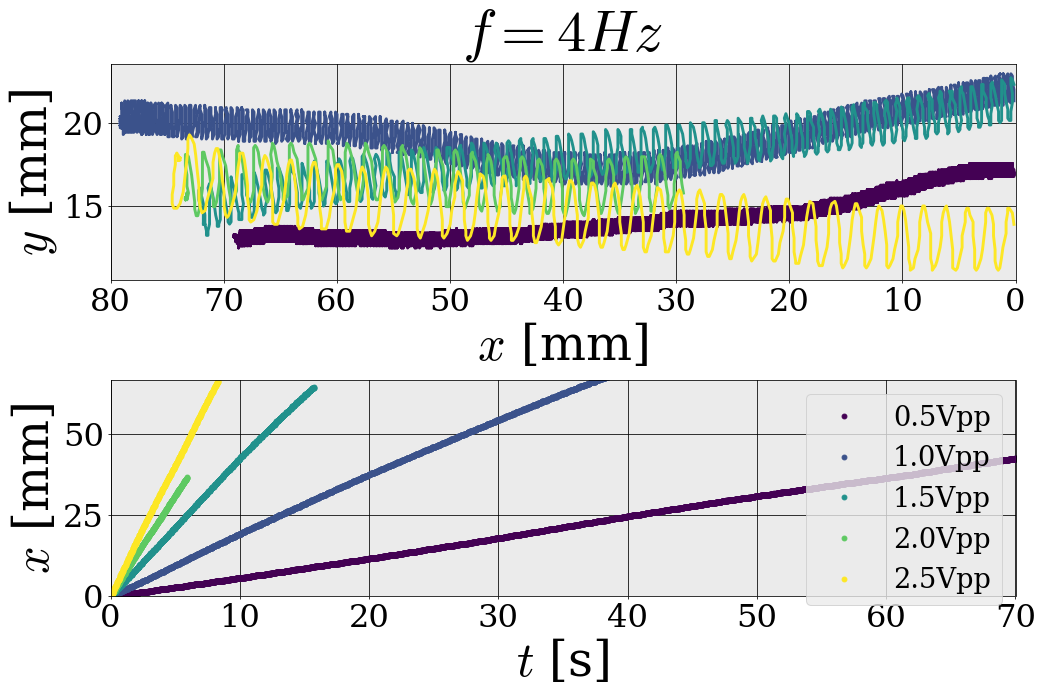

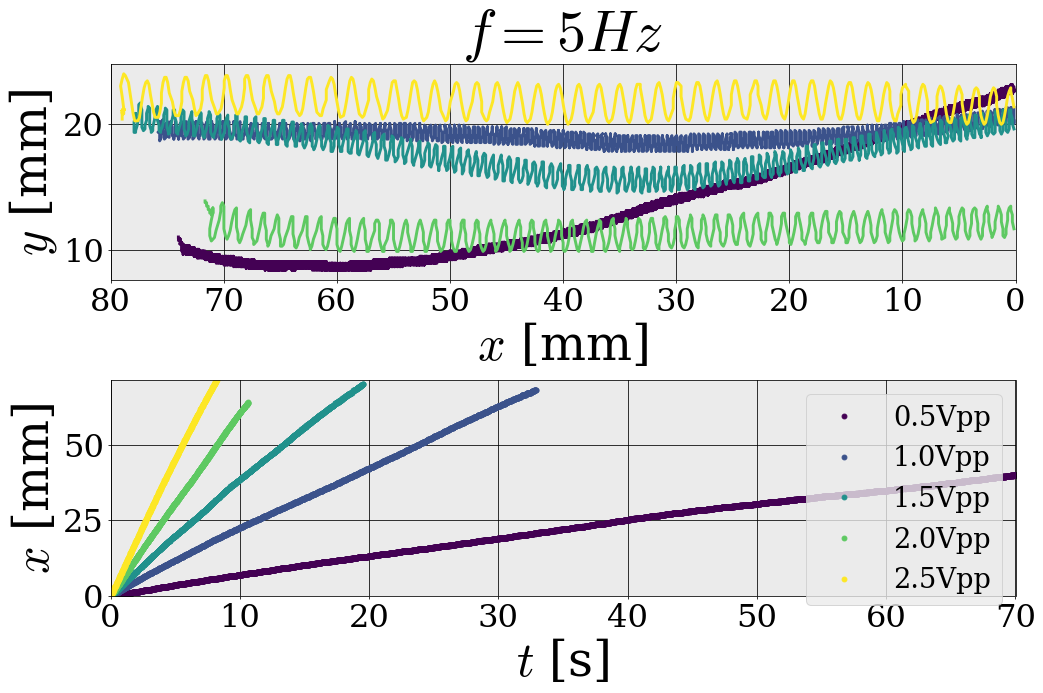

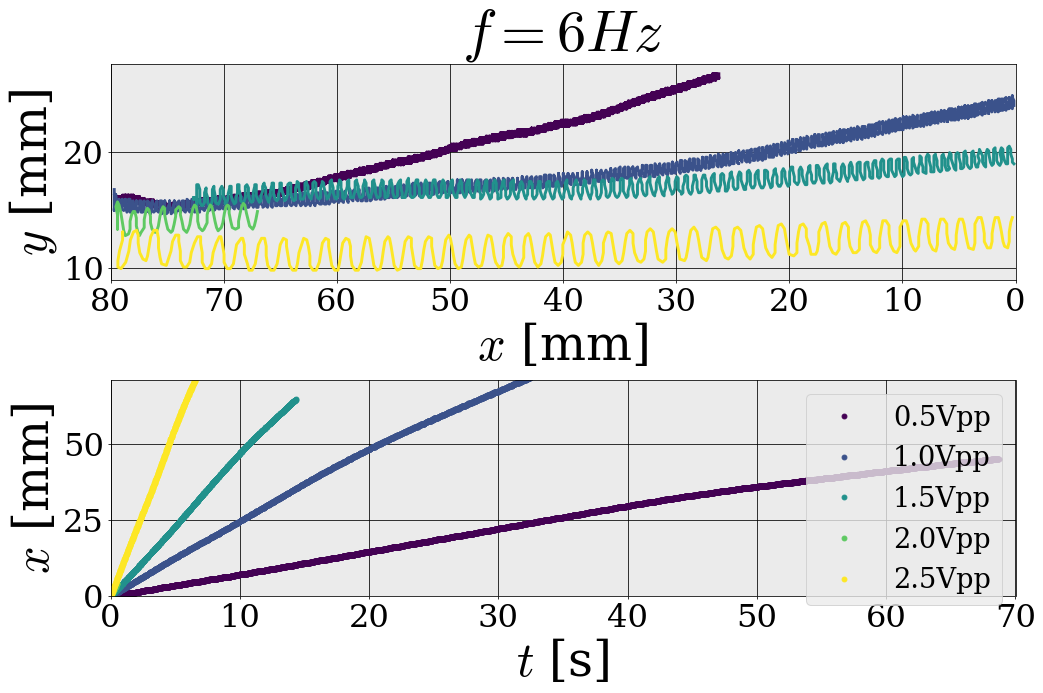

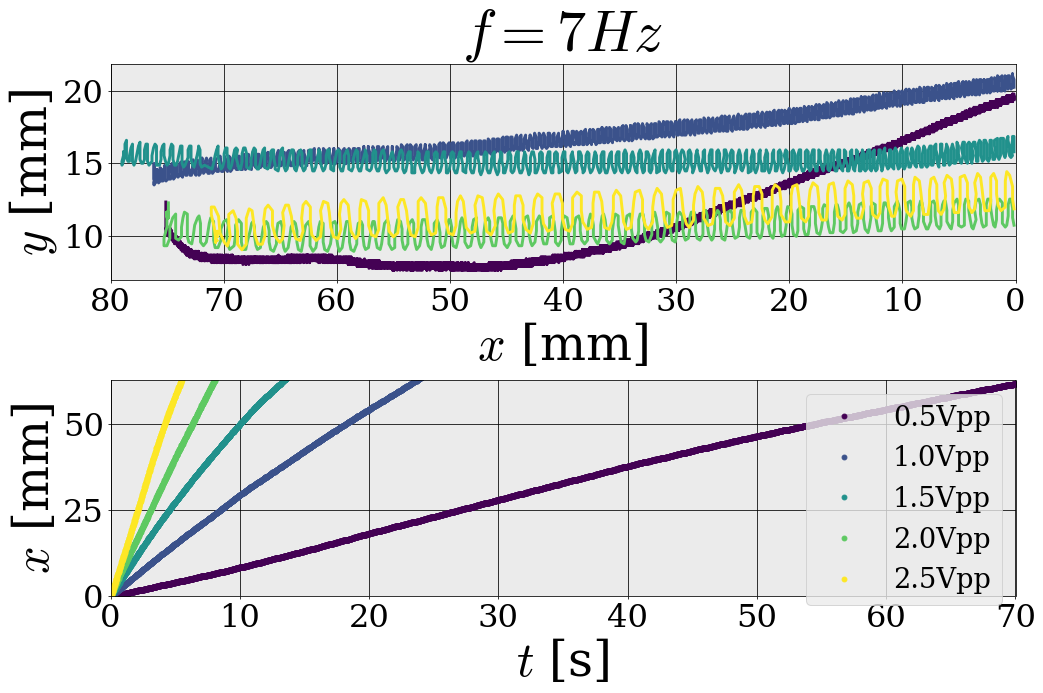

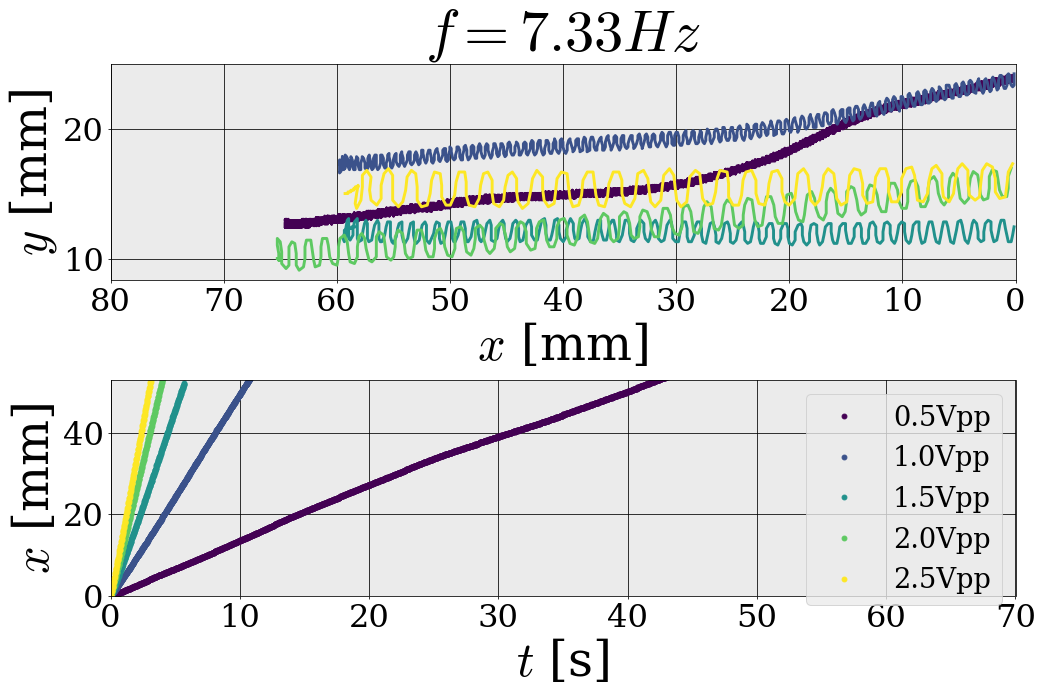

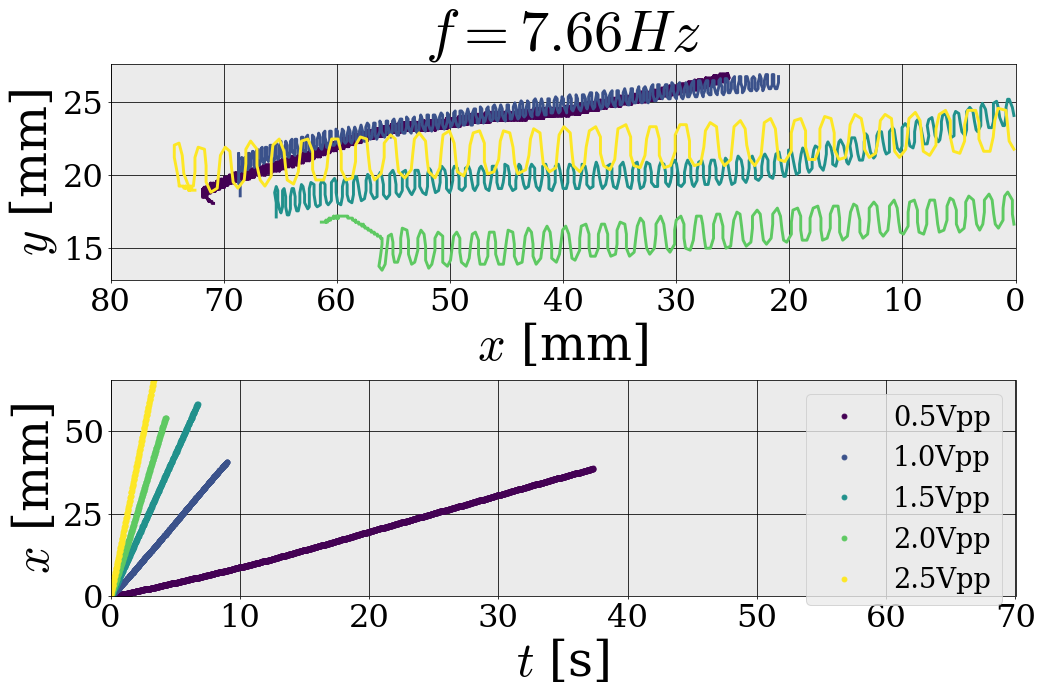

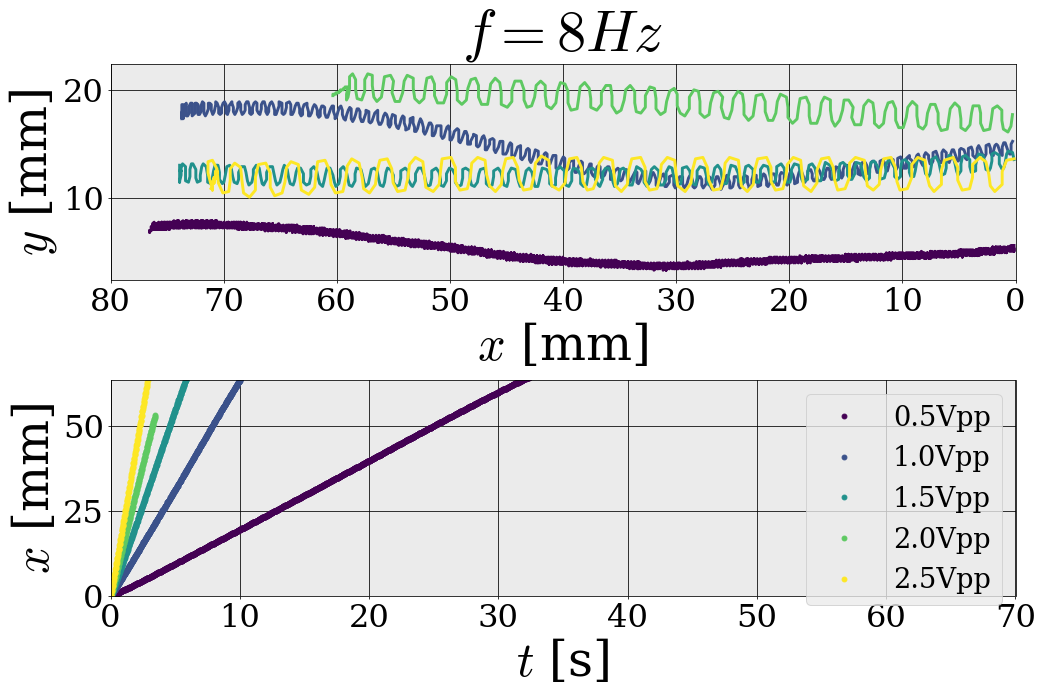

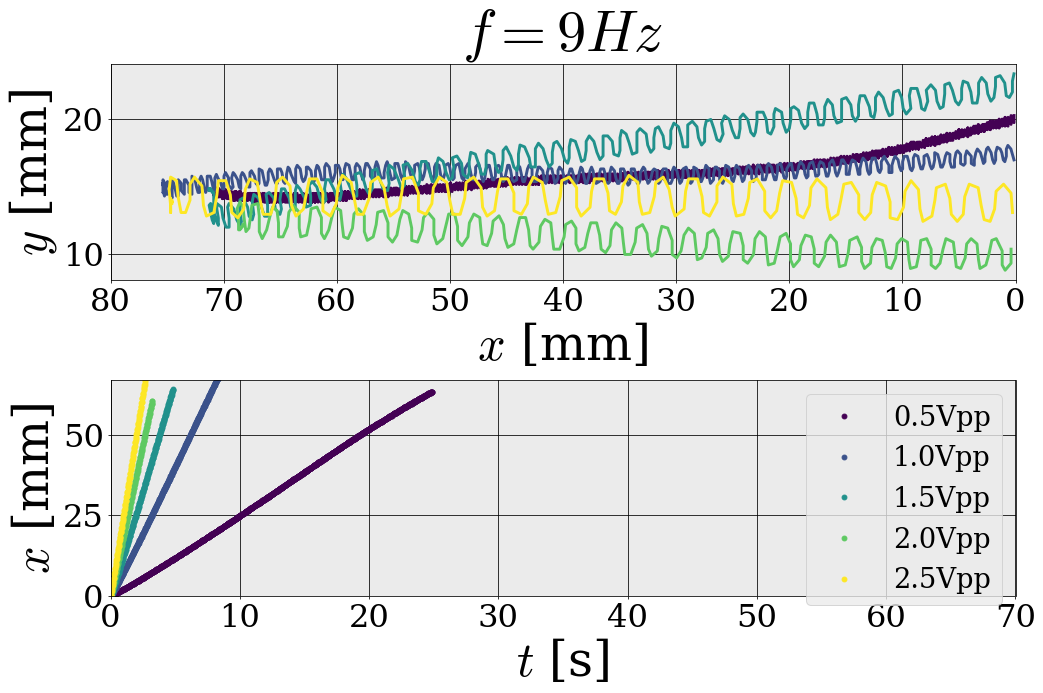

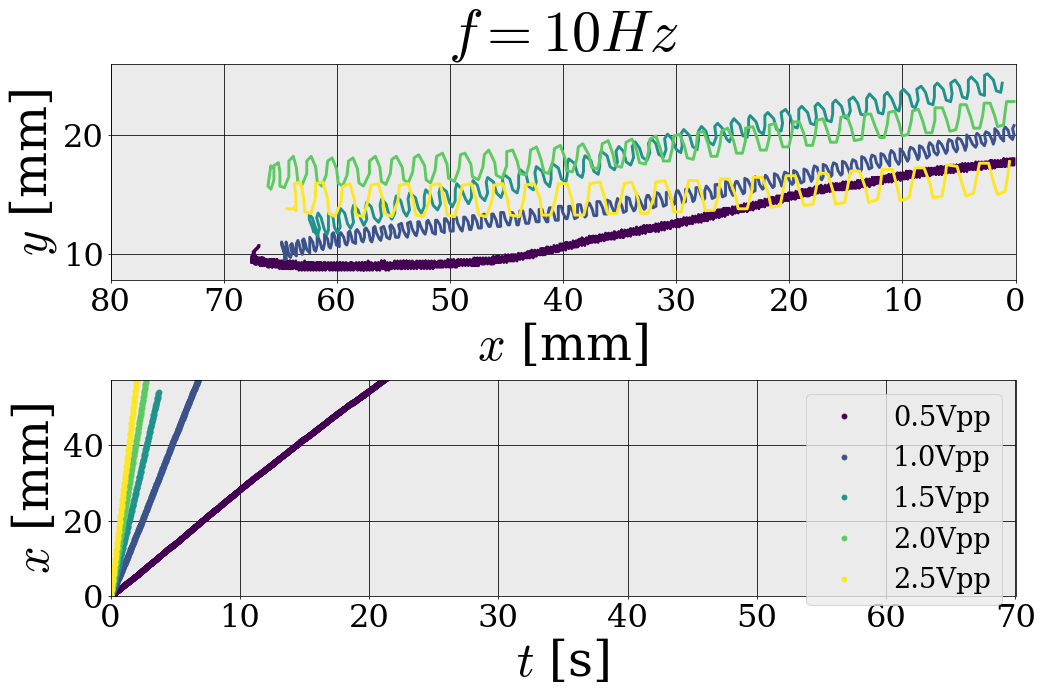

In [264]:
for currHz in FREQ_ARRAY:
    fval = float(currHz.split('Hz')[0].replace(',','.'))
    px_per_mm = calibrations[calibrations['freq [Hz]']==fval]
    filtered_namelist = filenamelist[filenamelist['name'].str.contains(r'\b{}\b'.format(currHz))]
    df_data = [pd.read_csv(f'ECO20-45mm/cabeza/{f}') for f in filtered_namelist.name]
    avg_start = np.average([x['x'][0]/px_per_mm['calibracion [px/mm]'].iloc[i] for i,x in  enumerate(df_data)]) #We compute the average x-position to make them run all from the same spot.
        
    #We plot everything on the same two plots
    fig, [ax1, ax2] = plt.subplots(2, 1)

    for filename,df_txy in zip(filtered_namelist.to_numpy(),df_data):
                
        #We retrieve the metadata of our measurements from the filename
        s = filename[0].split('-')
        v,f = s[0],s[1][:-4]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        
        curr_px_per_mm = px_per_mm[px_per_mm['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
        
        #Setting colors for our datapoints
        volt_color = cmap_v(norm_v(vval))

        #We retrieve the data from our dataframe
        t,x,y = df_txy['t']/FRAME_PER_SECOND, df_txy['x']/curr_px_per_mm, df_txy['y']/curr_px_per_mm
        
        #We center our x-positions
        x_recentered = x - (x[0]-avg_start)
        
        nonconstant_indexs = np.where(x_recentered<=avg_start*0.9)[0]
        
        if nonconstant_indexs.size>0:
            x_nonconstant = x_recentered[nonconstant_indexs]
            t_nonconstant = t[nonconstant_indexs] - t[nonconstant_indexs[0]]
        else:
            x_nonconstant = x_recentered
            t_nonconstant = t
        # Save the non-constant values
        # pd.DataFrame().assign(x = x_nonconstant).assign(t = t_nonconstant).to_csv(f'ECO20-45mm/slopes-xt/cabeza/{v}-{f}.csv', index = False)
        #Plotting
        ax1.plot(x, y, color = volt_color, lw=3)
        
        x_nonconstant = np.abs(x_nonconstant - x_nonconstant.max())
        
        ax2.plot(t_nonconstant, x_nonconstant , '.',label=f'{vval}Vpp', color = volt_color, ms=10 )  
    #Axes configuration
    ax1.set_xlabel('$x$ [mm]')
    ax1.set_ylabel('$y$ [mm]')
    ax1.set_title(f'$f={currHz}$')
    ax1.set_xlim([30,0])
    ax1.set_xlim([80,0])

    ax2.set_xlabel('$t$ [s]')
    ax2.set_ylabel('$x$ [mm]')
    ax2.set_ylim([0,(max(x_nonconstant))])
    ax2.set_xlim([0,70])
    
    handles, labels = ax2.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax2.legend(handles, labels)
    
    fig.tight_layout()
    # fig.savefig(f'{currHz}-comparacion.svg', bbox_inches='tight')
    # fig.savefig(f'{currHz}-comparacion.png', bbox_inches='tight')

### x(t) con pendiente (presentación)

In [ ]:
df_x_t = pd.read_csv('datos\\ECO20-45mm\\cabeza\\1,00Vpp-3Hz.csv')
v = '1,00Vpp' 
vval = 1.0
f = '3Hz'
t,x,y = np.array(df_x_t['t']/FRAME_PER_SECOND), np.array(df_x_t['x']/PX_PER_MM), df_x_t['y']/PX_PER_MM
x = -x + np.max(x)
# x_recentered = x - (x[0]-avg_start)

In [ ]:
norm = plt.Normalize(0.5,2.5)
cmap = plt.colormaps.get_cmap('viridis')
colorscale = plt.cm.ScalarMappable(norm, cmap)



fig, ax = plt.subplots()
ax.plot(t, x, '.', color = cmap(norm(vval)))

# SLOPE

t_mid = np.array([t[1850], t[2350]])
x_mid = np.array([x[1850]-10, x[2350]-10])

# Calculate slope
slope = np.diff(x_mid) / np.diff(t_mid)

ax.plot(t_mid, x_mid, color='r', lw=3)
ax.plot([t_mid[0], t_mid[1]], [x_mid[0], x_mid[0]], color='r', lw=3)
ax.plot([t_mid[1], t_mid[1]], [x_mid[0], x_mid[1]], color='r', lw=3)

ax.text(t_mid[0], x_mid[0]-5, f'v = {round(slope[0], 1)} mm/s', fontsize=24, color='r')


# INSET AXES
# x1, x2, y1, y2 = t[275], t[425], x[275]-1, x[425]  # subregion of the original image

# axins = ax.inset_axes(
#     [0.08, 0.5, 0.40, 0.4],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# axins.plot(t[275:425], x[275:425], '.', color = cmap(norm(vval)))
# axins.grid(None)
# ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_title(f'$V$ = 1.0 $\\text{{Hz}}$  $f$ = 3.0 $\\text{{Hz}}$')
ax.set_xlabel(f'$t$ $[\\text{{s}}]$')
ax.set_ylabel(f'$x$ $[\\text{{mm}}]$')

# fig.savefig(f'gráficos\\x(t)_1Vpp_3Hz.png')

## Velocidad terminal en función de f y V

### Sin líneas que unen, para la presentación

In [5]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/slopes-xt/cabeza') if '.csv' in filepath])
filenamelist = pd.DataFrame().assign(name = csv_names)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'ECO20-45mm/slopes-xt/cabeza'

In [6]:
f_lineal = lambda x,a,b: a*x + b

FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7.33Hz','7.66Hz','8Hz','9Hz','10Hz']
# FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','8Hz','9Hz','10Hz']
VOLT_ARRAY = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

FREQ_ARRAY_VALUES = [2,3,4,5,6,7,7.33,7.66,8,9,10]
# FREQ_ARRAY_VALUES = [2,3,4,5,6,7,8,9,10]
VOLT_ARRAY_VALUES = [0.5,1,1.5,2,2.5,3,3.5,4]

#Creating the colormap
norm_v = plt.Normalize(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(FREQ_ARRAY_VALUES[0],FREQ_ARRAY_VALUES[-1])
cmap_f = plt.colormaps.get_cmap('viridis')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

df_slope = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES,dtype=object)
df_amplitude = pd.DataFrame(index=VOLT_ARRAY_VALUES, columns=FREQ_ARRAY_VALUES,dtype=object)

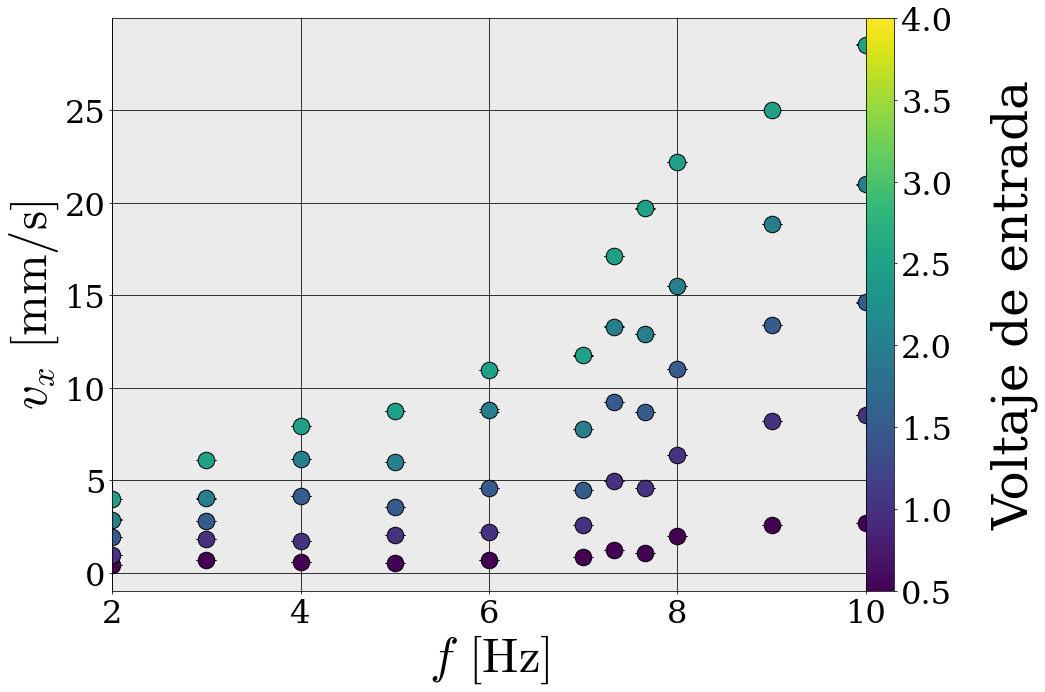

In [26]:
fig, ax = plt.subplots()

for currHz in FREQ_ARRAY:
    
    fval = float(currHz.split('Hz')[0].replace(',','.'))
    filtered_namelist = filenamelist[filenamelist['name'].str.contains(r'\b{}\b'.format(currHz))]
    df_data = [pd.read_csv(f'ECO20-45mm/slopes-xt/cabeza/{f}') for f in filtered_namelist.name]


    for filename,df_txy in zip(filtered_namelist.to_numpy(),df_data):
        
        #We retrieve the metadata of our measurements from the filename
        s = filename[0].split('-')
        v,f = s[0],s[1][:-4]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        # print(f' {v}-{f} => parametros: {popt[0]}, {popt[1]} ; errores: {err_popt[0]}, {err_popt[1]} ')
        
        df_slope.loc[vval,fval] = (popt[0],err_popt[0])
        
        # Plotting
        ax.errorbar(fval, np.abs(popt[0]), markerfacecolor = volt_color, fmt='o',
                    yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                    ms=17, elinewidth=2, lw=3, capsize=10)

        
# Colorbar configuration

cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

#Axes configuration
ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()

### Con líneas que unen (presentación)

Text(0, 0.5, 'Voltaje de entrada')

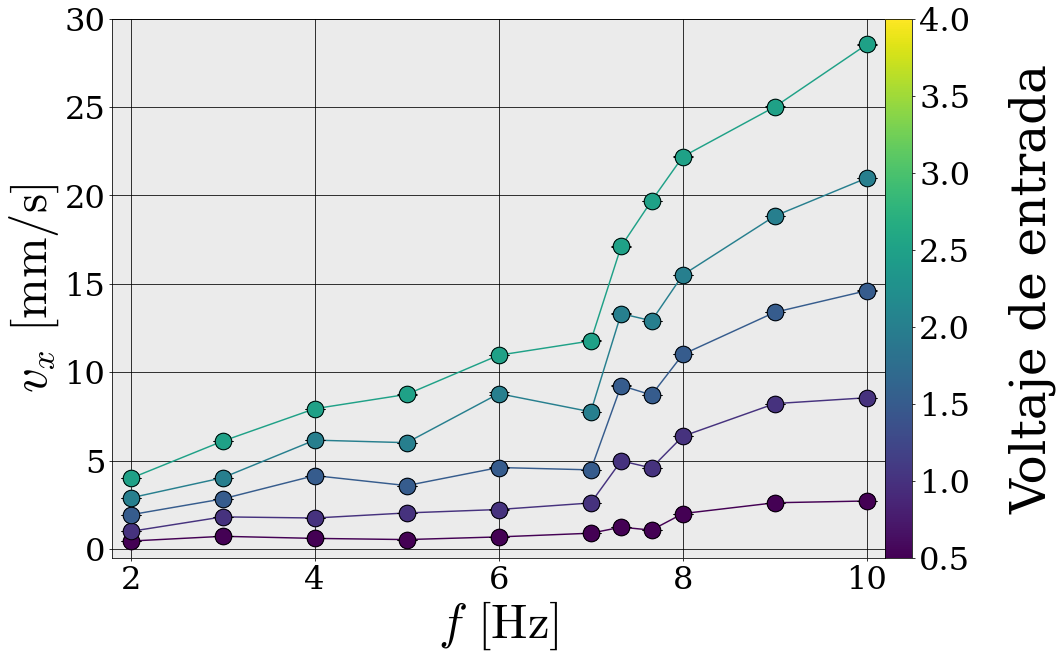

In [268]:
fig,ax = plt.subplots()
for row in df_slope.iterrows():
    volt_color = cmap_v(norm_v(row[0]))
    try:
        values = [row[1].iloc[i][0] for i in np.arange(len(row[1]))]
        errors = [row[1].iloc[i][1] for i in np.arange(len(row[1]))]
        ax.plot(FREQ_ARRAY_VALUES,np.abs(values), 'o-', ms=17, color=volt_color)
        ax.errorbar(FREQ_ARRAY_VALUES, np.abs(values), markerfacecolor = volt_color, fmt='o',
                yerr = errors, xerr = None, color = 'k', ecolor = 'k',
                ms=17, elinewidth=2, lw=3, capsize=10)
    except:
        pass

ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')
ax.set_xlim([1.8,10.2])
ax.set_ylim([-.5,30])
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

# Gráficos para el fin de la cola

In [8]:
npz_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/amplitud_cola') if '.npz' in filepath])

## Desfasaje

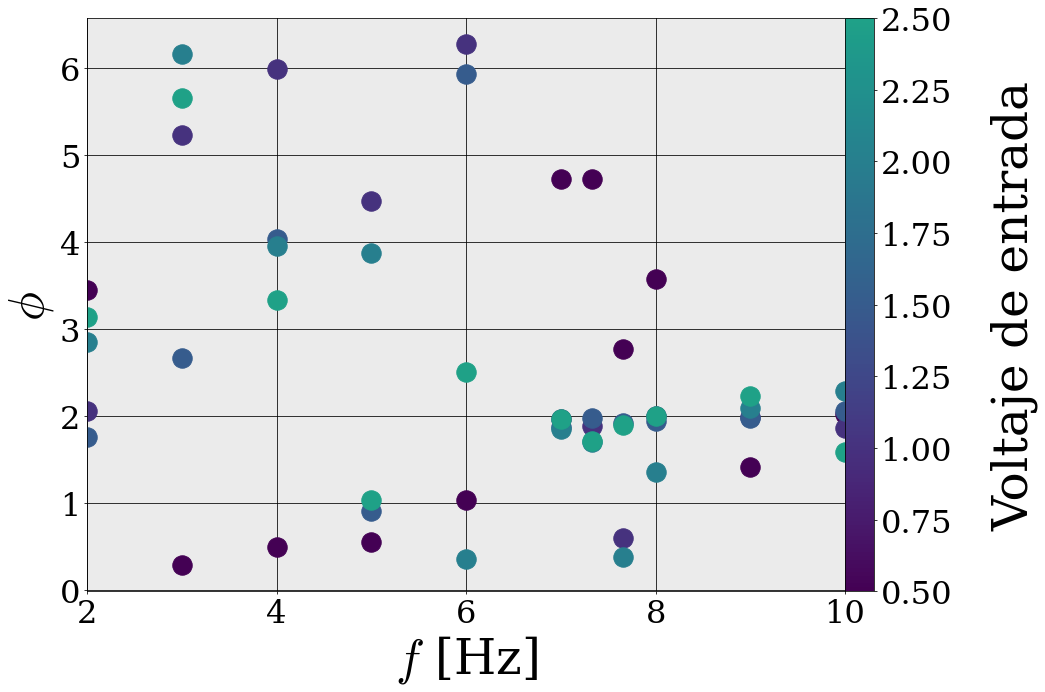

In [270]:
index_start = 0
values_dict = dict({})

fig_phi, ax2 = plt.subplots()

for currHz in FREQ_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
        
    values_dict[f'{currHz}'] = np.array([])

    for rotated_tail,filename in zip(rotated_tails,filtered_namelist):

        amplitudes = np.array([(tail[1][0], tail[1][-1]) for tail in rotated_tail])
        head_amplitude = amplitudes[:,0]
        tail_amplitude = amplitudes[:,1]
        
        t_tail = np.arange(tail_amplitude.size)
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))

        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
                        
        tail_peaks = np.array(find_peaks(tail_amplitude)[0])
        head_peaks = np.array(find_peaks(head_amplitude)[0])
        
        min_peaks = min(len(tail_peaks),len(head_peaks))
        
        t_tail_peaks = t_tail[tail_peaks][:min_peaks]
        t_head_peaks = t_tail[head_peaks][:min_peaks]
        
        time_shift = np.mean((t_tail_peaks - t_head_peaks))%(2*np.pi)
        
        values_dict[f'{currHz}'] = np.append(values_dict[f'{currHz}'],time_shift)
        
        ax2.plot(fval, time_shift , 'o', color = volt_color, ms=20)
        

    ax2.set_xlabel('$f$ [Hz]')
    ax2.set_ylabel('$\phi$')
    

#Colorbar configuration
cbar_term = fig_phi.colorbar(colorscale_v, ax=ax2, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig_phi.tight_layout()

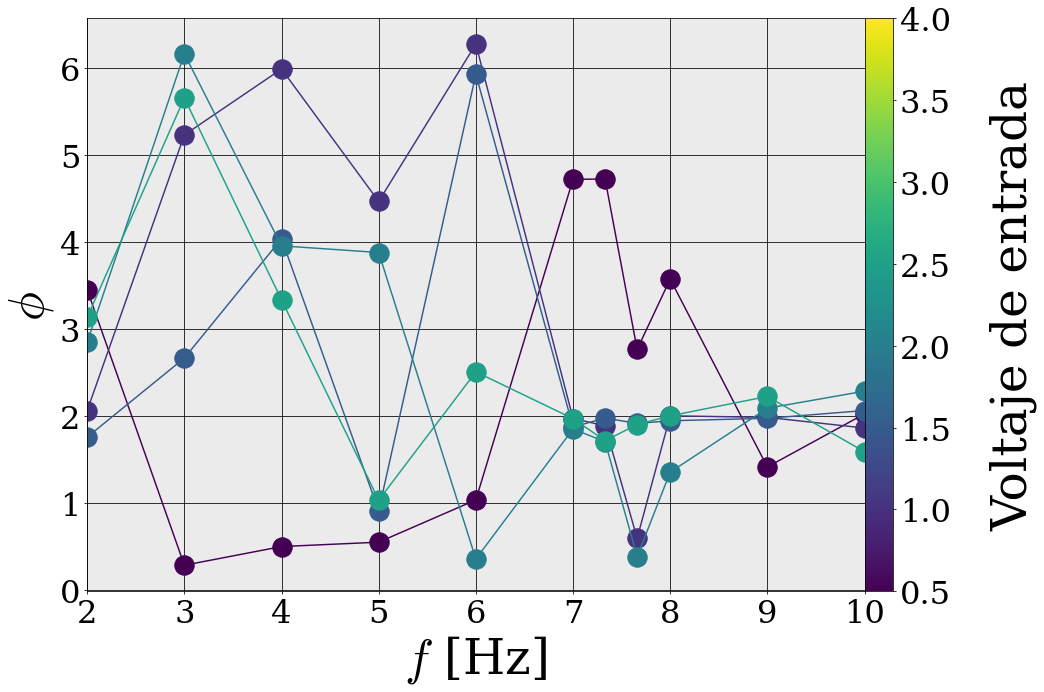

In [271]:
fig,ax = plt.subplots()
for i,vval in enumerate(VOLT_ARRAY_VALUES):
    try:
        volt_color = cmap_v(norm_v(vval))
        values = np.array([values_dict[currHz][i] for currHz in FREQ_ARRAY])
        ax.plot(FREQ_ARRAY_VALUES,values, 'o-', ms=20, color=volt_color)
    except:
        pass
    
ax.set_xlabel('$f$ [Hz]')
ax.set_ylabel('$\phi$')    
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()

### Velocidad de fase

/tmp/ipykernel_2349733/3493632272.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['freq [Hz]']==fval][calibrations['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/3493632272.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['freq [Hz]']==fval][calibrations['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/3493632272.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['freq [Hz]']==fval][calibrations['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/3493632272.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['freq [Hz]']==fval][calibrations['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/349363227

Text(0, 0.5, 'Voltaje de entrada')

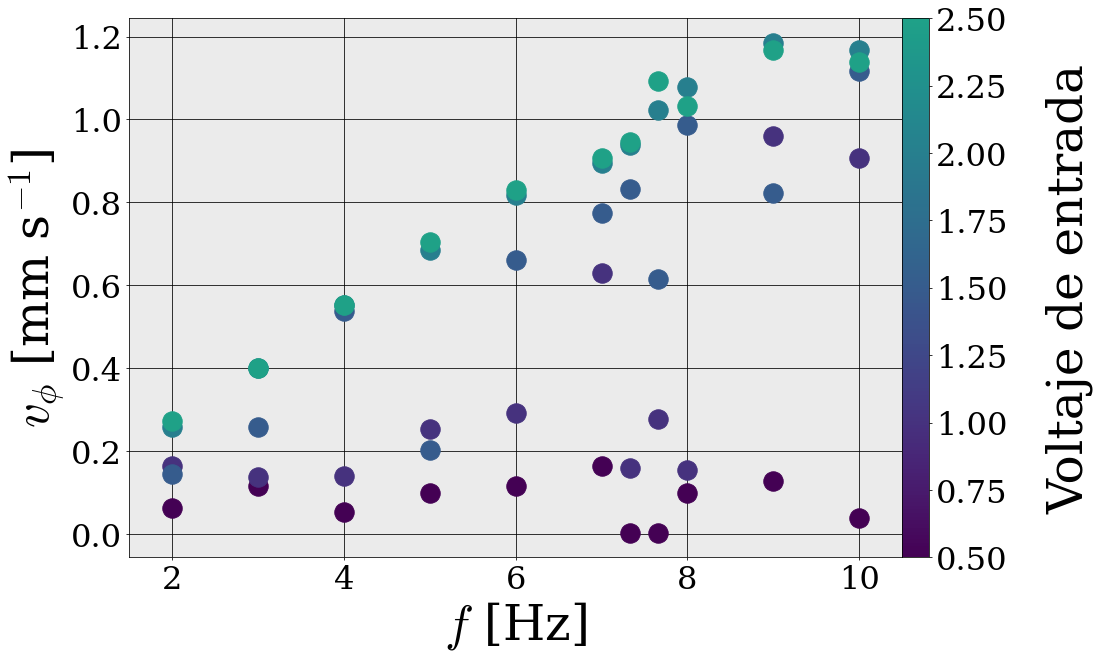

In [25]:
index_start = 0
values_dict = dict({})

fig, ax = plt.subplots()

for currHz in FREQ_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails_array = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    
    fval = float(currHz.split('Hz')[0].replace(',','.'))
    values_dict[fval] = dict({})
    values_dict[fval]['value'] = np.array([])
    values_dict[fval]['error'] = np.array([])

    for rotated_tail,filename in zip(rotated_tails_array,filtered_namelist):
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        px_per_mm = calibrations[calibrations['freq [Hz]']==fval][calibrations['volt [Vpp]']==vval]['calibracion [px/mm]'].iloc[0]
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))

        freq_arr = np.linspace(0,30, len(rotated_tail)//2 + 1)
        space_arr = np.linspace(0,len(rotated_tail[0][0])//2, len(rotated_tail[0][0])//2 + 1)*px_per_mm

        w_max = []
        k_max = []
        for time_tail in rotated_tail[:,1].T:
            w_tail = np.abs(np.fft.rfft(time_tail))**2
            w_max.append(freq_arr[np.argmax(w_tail)])

        for space_tail in rotated_tail[:,1]:
            k_tail = np.abs(np.fft.rfft(space_tail))**2
            k_max.append(space_arr[np.argmax(k_tail[1:]) + 1])
        
        kmax_mean = np.mean(k_max)
        wmax_mean = np.mean(w_max)

        kmax_error = np.std(k_max)/np.sqrt(len(k_max))
        wmax_error = np.std(w_max)/np.sqrt(len(w_max))

        v = wmax_mean/kmax_mean
        v_error = v*np.sqrt((wmax_error/wmax_mean)**2 + (kmax_error/kmax_mean)**2)

        
        values_dict[fval]['value'] = np.append(values_dict[fval]['value'],v)
        values_dict[fval]['error'] = np.append(values_dict[fval]['error'],v_error)
        
        ax.plot(fval, v , 'o', color = volt_color, ms=20)
        
ax.set_xlabel('$f$ [Hz]')
ax.set_ylabel('$v_{\phi}$ [mm s$^{-1}$]')

ax.set_xlim([1.5,10.5])

#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

/tmp/ipykernel_2349733/1014274025.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/1014274025.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/1014274025.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/1014274025.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2349733/1014274025.py:4: UserWarning: Boolean

Text(0, 0.5, 'Frecuencia de forzado')

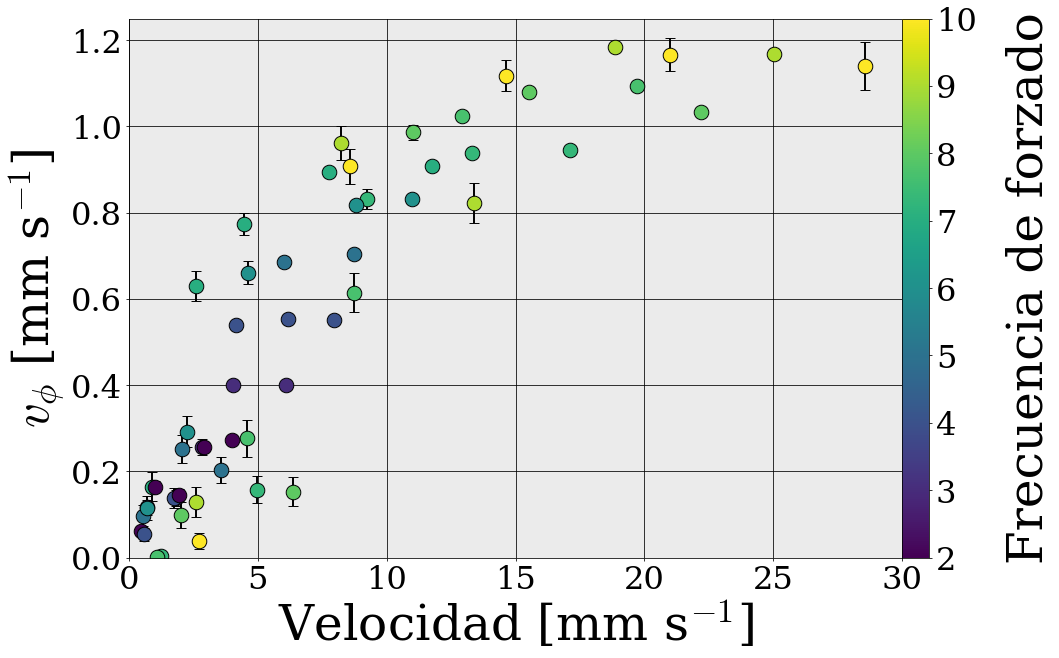

In [35]:
fig,ax = plt.subplots()
for i, row in df_slope.dropna().iterrows():
    for j, col in row.items():
        px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
        vel = np.abs(col[0])
        delta_vel = col[1]
        vphi = values_dict[j]['value'][VOLT_ARRAY_VALUES.index(i)]
        delta_vphi = values_dict[j]['error'][VOLT_ARRAY_VALUES.index(i)]
        ax.errorbar(vel, vphi, xerr=delta_vel, yerr=delta_vphi, fmt='o', color='k',markerfacecolor=cmap_f(norm_f(j)), lw=10 ,ecolor='k', elinewidth=2, capsize=5, ms=15)

ax.set_xlabel('Velocidad [mm s$^{-1}$]')
ax.set_ylabel('$v_{\phi}$ [mm s$^{-1}$]')
ax.set_xlim([0,30])
ax.set_ylim([0,1.25])
cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks([f for f in FREQ_ARRAY_VALUES if f!=7.33 and f!=7.66])
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=30)


## Amplitud

### Amplitud en función de frecuencia agrupado por voltaje

In [12]:
npz_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/forma_cola_rotada') if '.npz' in filepath])

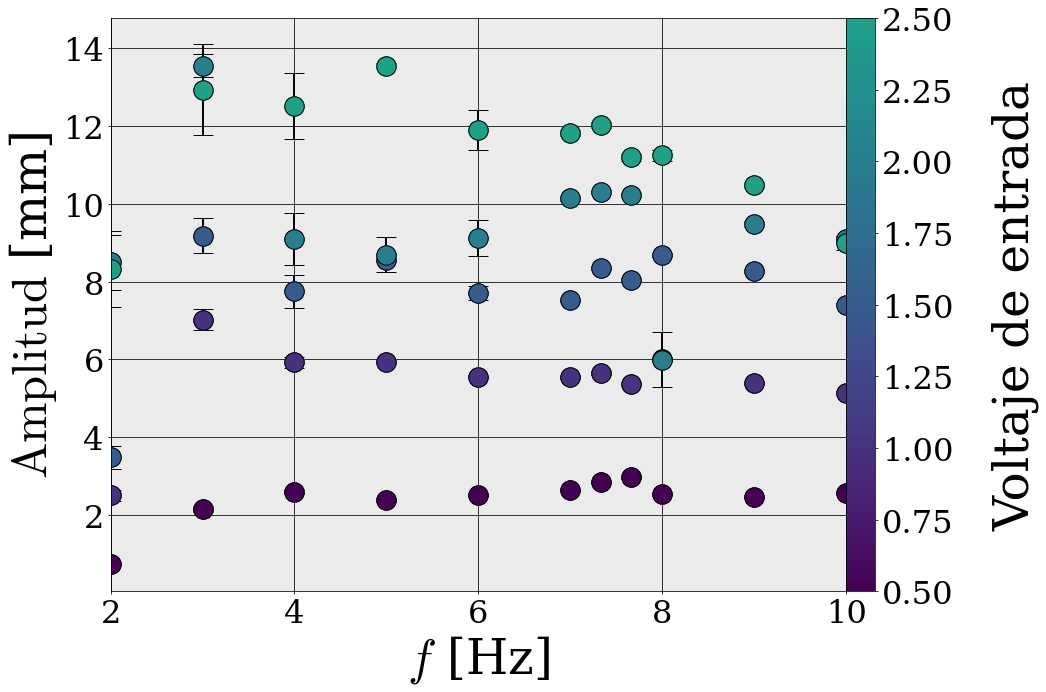

In [14]:
values_dict = dict({})
fig, ax = plt.subplots()

for currHz in FREQ_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)

    fval = float(currHz.split('Hz')[0].replace(',','.'))
    values_dict[fval] = dict({})
    values_dict[fval]['value'] = np.array([])
    values_dict[fval]['error'] = np.array([])

    
    for rotated_tail,filename in zip(rotated_tails,filtered_namelist):
        tail_extremes = np.array([(tail[1][0], tail[1][-1]) for tail in rotated_tail])
        head_position = tail_extremes[:,0]
        tail_position = tail_extremes[:,1]
        max_peaks, _ = find_peaks(tail_position)
        min_peaks, _ = find_peaks(-tail_position)

        lim = min(max_peaks.size,min_peaks.size)
        amplitud = np.array([])
        max_peaks = max_peaks[:lim]
        min_peaks = min_peaks[:lim]

        for (mP,MP) in zip (tail_position[min_peaks],tail_position[max_peaks]):
            amplitud = np.append(amplitud, (MP - mP)/2)
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)

        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))

        ax.errorbar(fval, amplitud.mean(), markerfacecolor = volt_color, fmt='o',
                    yerr = amplitud.std()/np.sqrt(len(amplitud)), xerr = None, color = 'k', ecolor = 'k',
                    ms=20, elinewidth=2, lw=3, capsize=10)

        values_dict[fval]['value'] = np.append(values_dict[fval]['value'],amplitud.mean())
        values_dict[fval]['error'] = np.append(values_dict[fval]['error'],amplitud.std()/np.sqrt(len(amplitud)))

        ax.plot(fval, amplitud.mean(), 'o', color= volt_color, ms=20)
        #Axes configuration
        ax.set_xlabel('$f$ [Hz]')
        ax.set_ylabel('$\\text{Amplitud}$ [mm]')    

#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()

In [278]:
values_dict[8.0]['value'][3] = 10.602318996162069
values_dict[8.0]['error'][3] = 0.09456601311843016


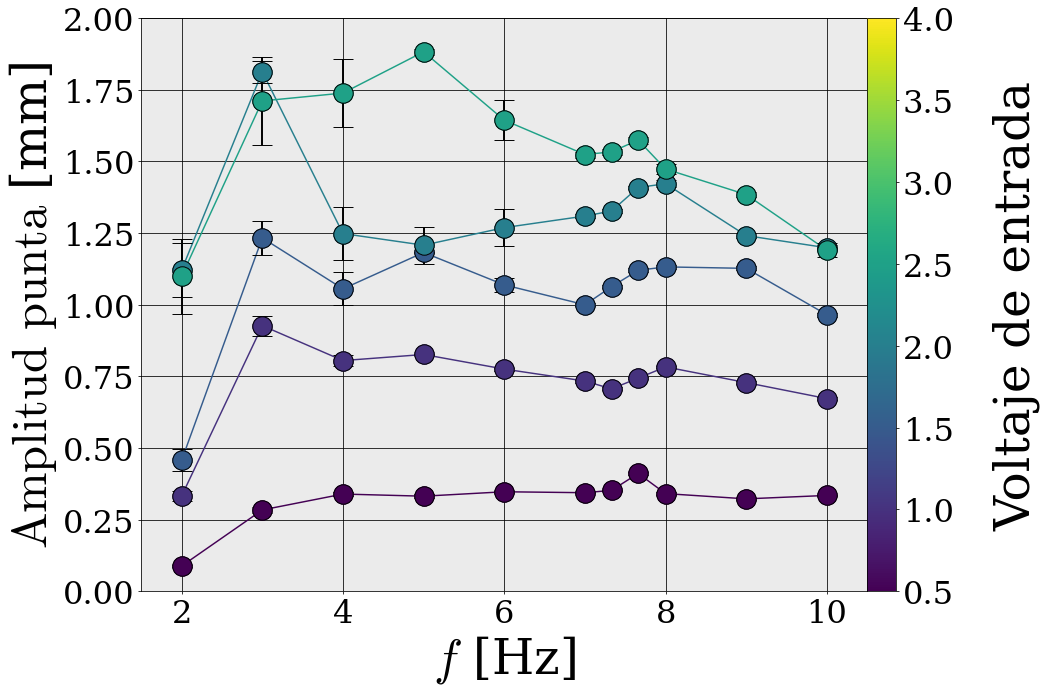

In [279]:
fig,ax = plt.subplots()
for i,vval in enumerate(VOLT_ARRAY_VALUES):
    try:
        volt_color = cmap_v(norm_v(vval))
        px_per_mm = calibrations[calibrations['volt [Vpp]']==vval]
        values = np.array([values_dict[currHz]['value'][i]/px_per_mm[px_per_mm['freq [Hz]']==currHz]['calibracion [px/mm]'].iloc[0] for currHz in FREQ_ARRAY_VALUES])
        errors = np.array([values_dict[currHz]['error'][i]/px_per_mm[px_per_mm['freq [Hz]']==currHz]['calibracion [px/mm]'].iloc[0] for currHz in FREQ_ARRAY_VALUES])
        ax.plot(FREQ_ARRAY_VALUES, values , '-o', ms=20, color=volt_color)
        ax.errorbar(FREQ_ARRAY_VALUES, values , markerfacecolor = volt_color, fmt='o',
                yerr = errors, xerr = None, color = 'k', ecolor = 'k',
                ms=20, elinewidth=2, lw=3, capsize=10)
    except:
        pass
    
ax.set_xlabel('$f$ [Hz]')
ax.set_ylabel('$\\text{Amplitud punta}$ [mm]')   
ax.set_xlim([1.5,10.5])
ax.set_ylim([0,2]) 
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()


### Amplitud en función de voltaje agrupado por frecuencia

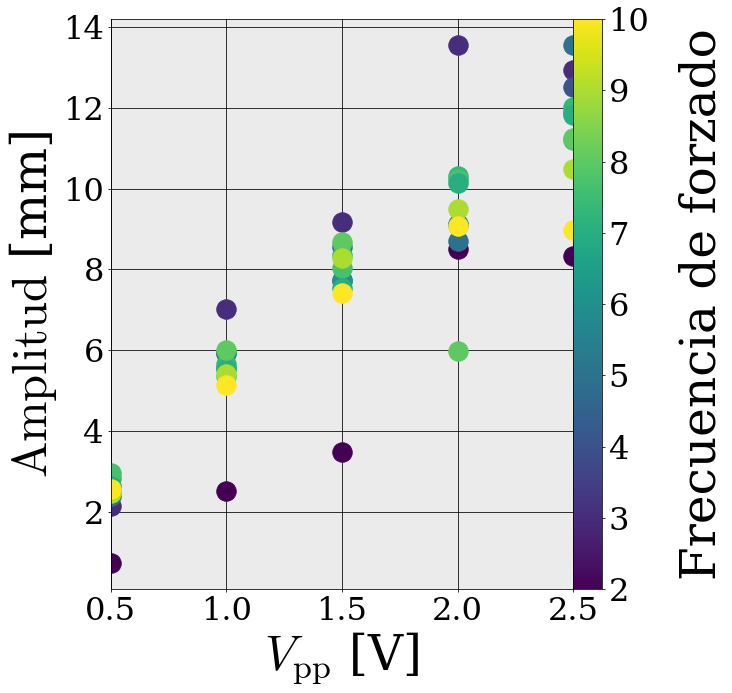

In [280]:
#Creating the colormap
index_start = 0

fig, ax1 = plt.subplots()
values_dict = dict({})

for currVolt in VOLT_ARRAY:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currVolt+r'\b',name.split('-')[0])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    vval = (float(currVolt.split('V')[0].replace(',','.')))
    values_dict[vval] = dict({})
    values_dict[vval]['value'] = np.array([])
    values_dict[vval]['error'] = np.array([])
    
    for rotated_tail,filename in zip(rotated_tails,filtered_namelist):
        tail_extremes = np.array([(tail[1][0], tail[1][-1]) for tail in rotated_tail])
        head_position = tail_extremes[:,0]
        tail_position = tail_extremes[:,1]
        max_peaks, _ = find_peaks(tail_position)
        min_peaks, _ = find_peaks(-tail_position)

        lim = min(max_peaks.size,min_peaks.size)
        amplitud = np.array([])
        max_peaks = max_peaks[:lim]
        min_peaks = min_peaks[:lim]

        for (mP,MP) in zip (tail_position[min_peaks],tail_position[max_peaks]):
            amplitud = np.append(amplitud, (MP - mP)/2)
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        fval = float(f.split('Hz')[0].replace(',','.'))

        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))

        ax.errorbar(vval, amplitud.mean(), markerfacecolor = freq_color, fmt='o',
                    yerr = amplitud.std()/np.sqrt(len(amplitud)), xerr = None, color = 'k', ecolor = 'k',
                    ms=20, elinewidth=2, lw=3, capsize=10)

        values_dict[vval]['value'] = np.append(values_dict[vval]['value'],amplitud.mean())
        values_dict[vval]['error'] = np.append(values_dict[vval]['error'],amplitud.std()/np.sqrt(len(amplitud)))

        ax1.plot(vval, amplitud.mean(), 'o', color= freq_color, ms=20)
        #Axes configuration
        ax1.set_xlabel('$V_{\\text{pp}}$ [V]')
        ax1.set_ylabel('$\\text{Amplitud}$ [mm]')    

#Colorbar configuration
cbar_term = fig.colorbar(colorscale_f, ax=ax1, location='right', orientation='vertical', pad=0, fraction=0.5)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=30)
fig.tight_layout()

In [282]:
values_dict[2.0]['value'][8] = 10.602318996162069
values_dict[2.0]['error'][8] = 0.09456601311843016

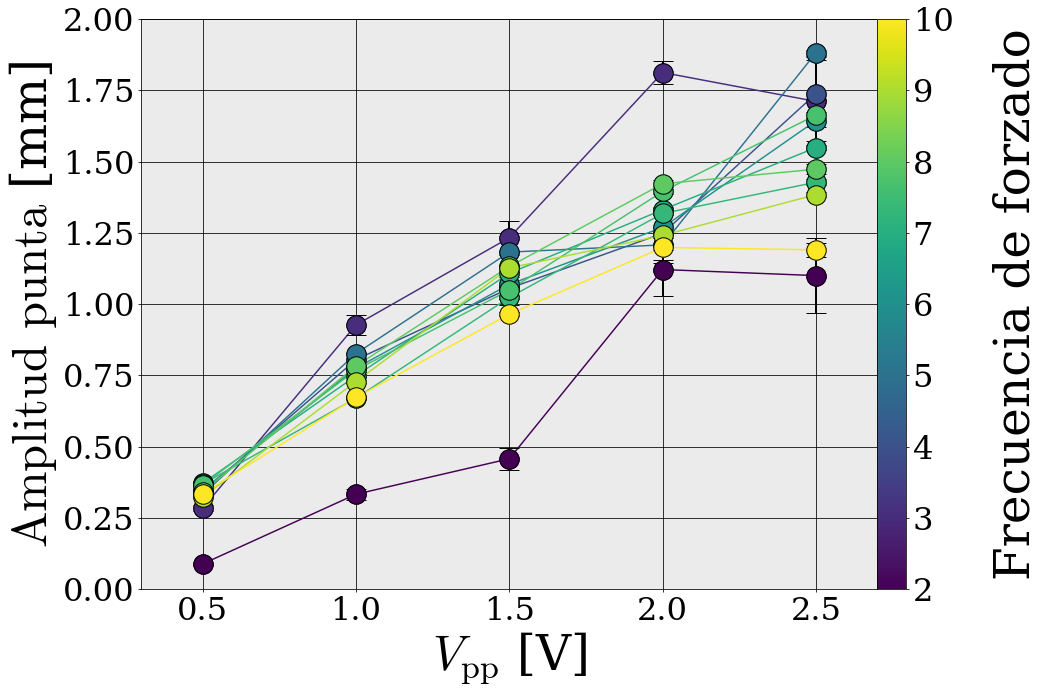

In [283]:
fig,ax = plt.subplots()
for i,fval in enumerate(FREQ_ARRAY_VALUES):
    freq_color = cmap_f(norm_f(fval))
    px_per_mm = calibrations[calibrations['freq [Hz]']==fval]
    values = np.array([values_dict[currVolt]['value'][i]/px_per_mm[px_per_mm['volt [Vpp]']==currVolt]['calibracion [px/mm]'].iloc[0] for currVolt in VOLT_ARRAY_VALUES[:5]])
    errors = np.array([values_dict[currVolt]['error'][i]/px_per_mm[px_per_mm['volt [Vpp]']==currVolt]['calibracion [px/mm]'].iloc[0] for currVolt in VOLT_ARRAY_VALUES[:5]])
    ax.plot(VOLT_ARRAY_VALUES[:5], values , '-o', ms=20, color=freq_color)
    ax.errorbar(VOLT_ARRAY_VALUES[:5], values , markerfacecolor = freq_color, fmt='o',
            yerr = errors, xerr = None, color = 'k', ecolor = 'k',
            ms=20, elinewidth=2, lw=3, capsize=10)
    
ax.set_xlabel('$V_{\\text{pp}}$ [V]')
ax.set_ylabel('$\\text{Amplitud punta}$ [mm]')   
ax.set_xlim([0.3,2.7])
ax.set_ylim([0,2]) 
cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks([f for f in FREQ_ARRAY_VALUES if f!=7.33 and f!=7.66])
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)
fig.tight_layout()


/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean

/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
/tmp/ipykernel_2104034/2597562677.py:8: UserWarning: Boolean

Text(0, 0.5, 'Frecuencia de forzado')

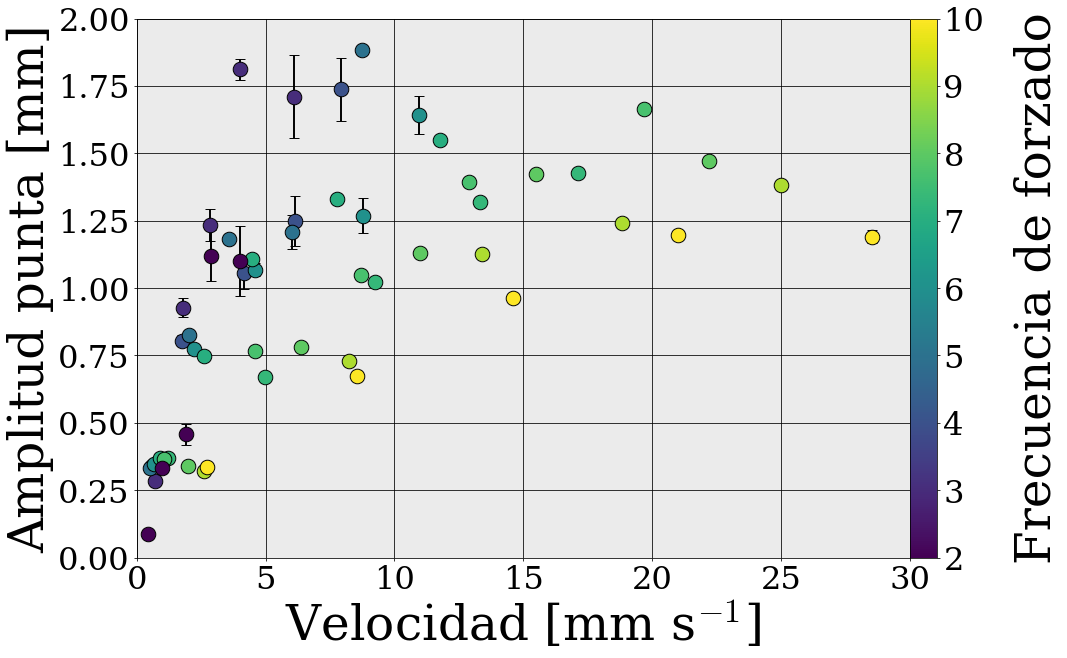

In [285]:
# amplitudes = []
# amplitude_errors = []
# velocities = []
# velocity_errors = []
fig,ax = plt.subplots()
for i, row in df_slope.dropna().iterrows():
    for j, col in row.items():
        px_per_mm = calibrations[calibrations['volt [Vpp]']==i][calibrations['freq [Hz]']==j]['calibracion [px/mm]'].iloc[0]
        vel = np.abs(col[0])
        delta_vel = col[1]
        amplitude = values_dict[i]['value'][FREQ_ARRAY_VALUES.index(j)]/px_per_mm
        delta_amp = values_dict[i]['error'][FREQ_ARRAY_VALUES.index(j)]/px_per_mm
        ax.errorbar(vel, amplitude, xerr=delta_vel, yerr=delta_amp, fmt='o', color='k',markerfacecolor=cmap_f(norm_f(j)), lw=10 ,ecolor='k', elinewidth=2, capsize=5, ms=15)

ax.set_xlabel('Velocidad [mm s$^{-1}$]')
ax.set_ylabel('Amplitud punta [mm]')
ax.set_xlim([0,30])
ax.set_ylim([0,2])
cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks([f for f in FREQ_ARRAY_VALUES if f!=7.33 and f!=7.66])
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=30)


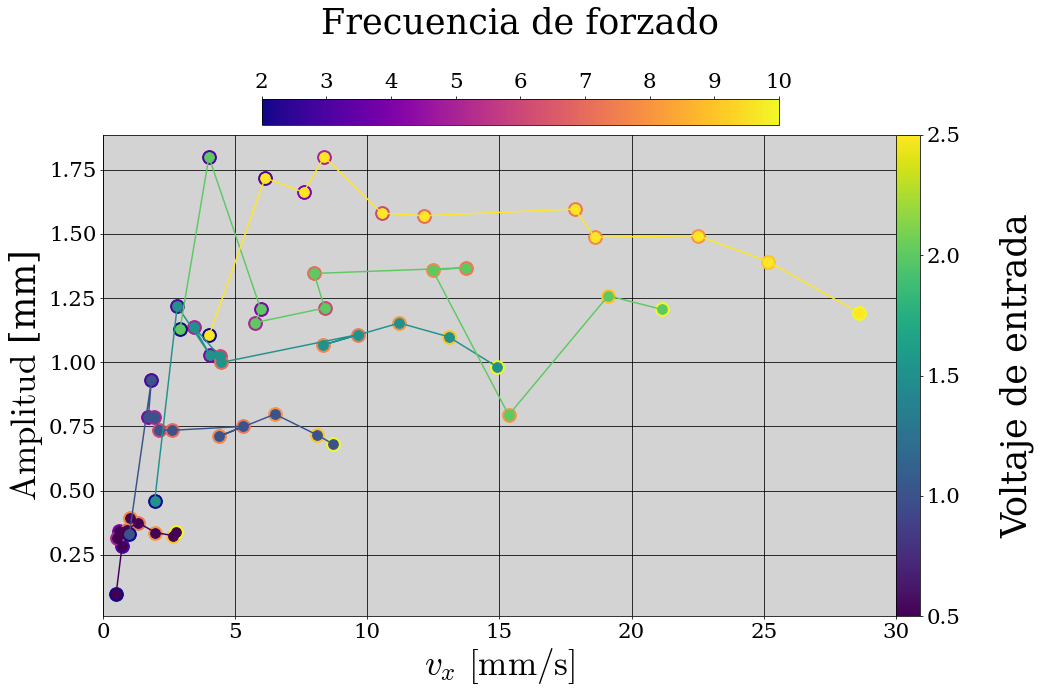

In [25]:
fig,ax = plt.subplots()

for i,vval in enumerate(df_amplitude.index):
    volt_color = cmap_v(norm_v(vval))
    slopes = np.array([vx[0] for vx in df_slope.iloc[i]])
    slope_errors = np.array([vx[1] for vx in df_slope.iloc[i]])
    amplitudes = np.array([amp[0] for amp in df_amplitude.iloc[i]])
    amplitude_errors = np.array([amp[1] for amp in df_amplitude.iloc[i]])
    ax.plot(np.abs(slopes), amplitudes,'o-', ms=10, color = volt_color)
    for i,fval in enumerate(FREQ_ARRAY_VALUES):
        freq_color = cmap_f(norm_f(fval))
        ax.scatter(np.abs(slopes[i]),amplitudes[i], s=200, color = freq_color)
    # ax.errorbar(np.abs(slopes), amplitudes, markerfacecolor = volt_color, fmt='o',
    #         yerr = amplitude_errors, xerr = slope_errors, color = 'k', ecolor = 'k',
    #         ms=10, elinewidth=2, lw=1, capsize=10)
    
ax.set_xlabel(f'$v_x$ $[\\text{{mm/s}}]$')
ax.set_ylabel('$\\text{Amplitud}$ [mm]')   
ax.set_xlim([0,30])
# ax.set_ylim([0,1.85])

cbar_term_f = fig.colorbar(colorscale_f, ax=ax, location='top', orientation='horizontal', pad=0.02, fraction=0.05)
cbar_term_f.ax.set_xlim(2,10)
cbar_term_f.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term_f.ax.set_xticks(np.arange(2,11))
cbar_term_f.ax.set_xlabel('Frecuencia de forzado',labelpad=40)


cbar_term_v = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term_v.ax.set_ylim(0.5,2.5)
cbar_term_v.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term_v.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term_v.ax.set_ylabel('Voltaje de entrada',labelpad=40)
fig.tight_layout()


## Gráficos para la forma del cuerpo

### Forma de la cola en función del voltaje para cada frecuencia

In [6]:
npz_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/forma_cola_rotada') if '.npz' in filepath])

rcParams['ytick.labelsize'] = 19

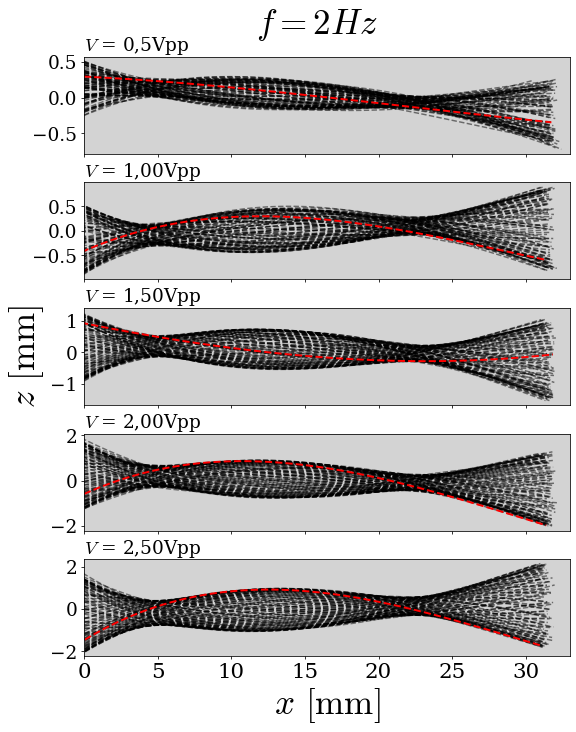

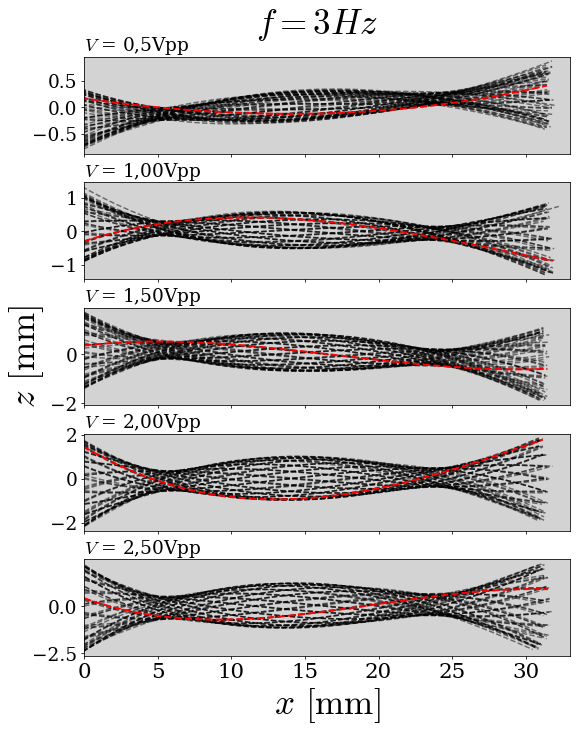

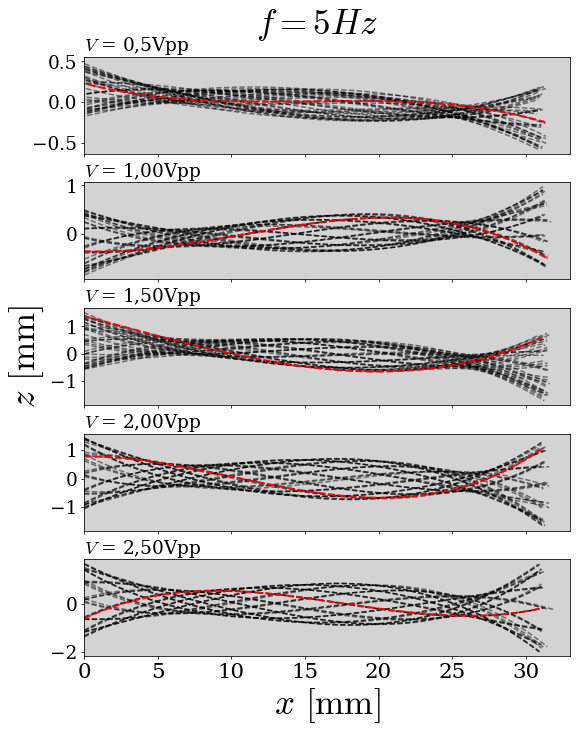

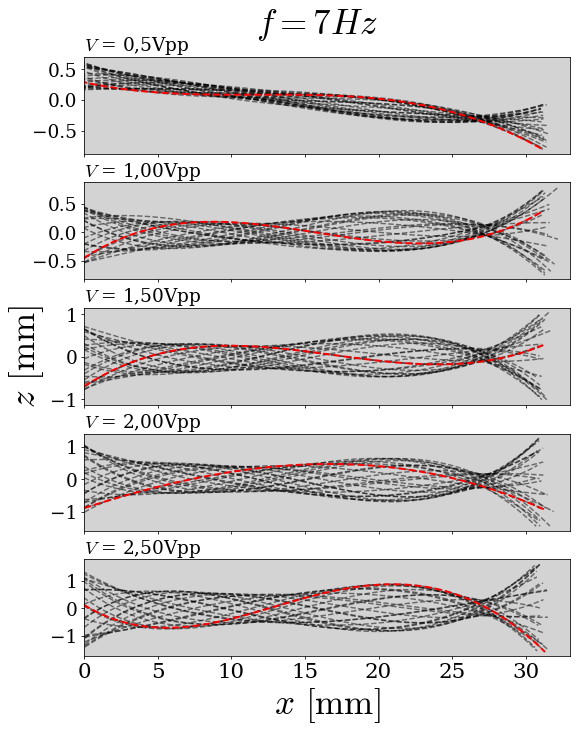

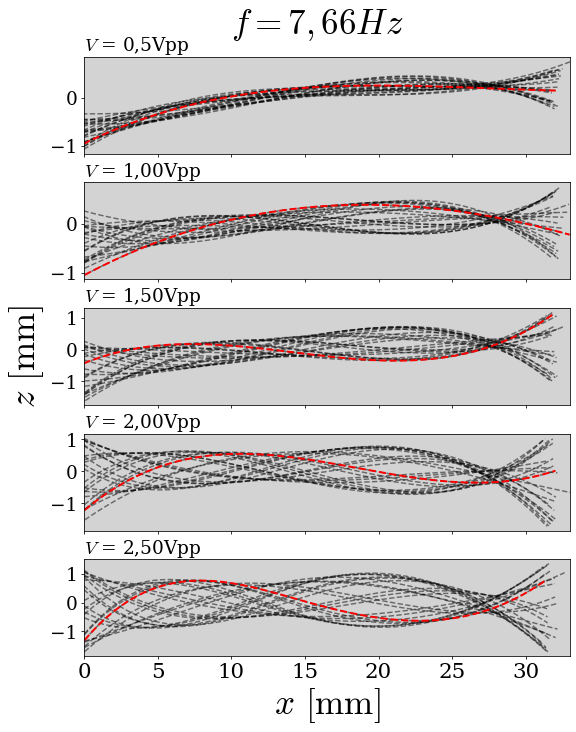

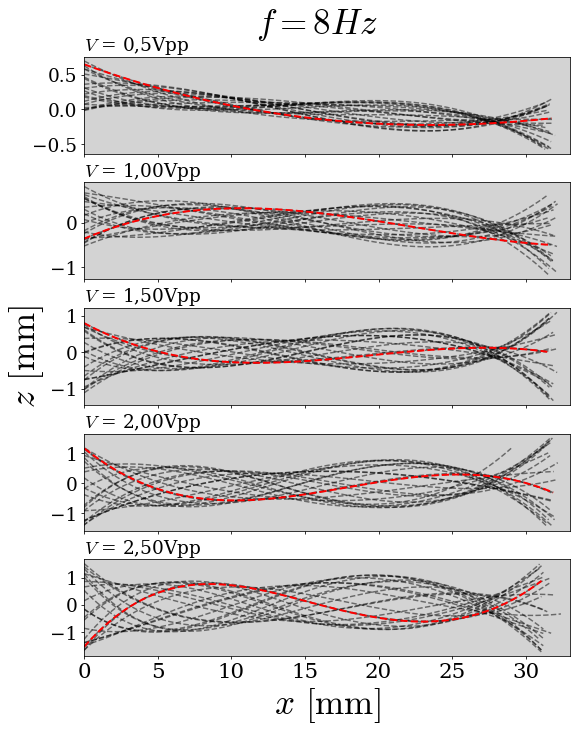

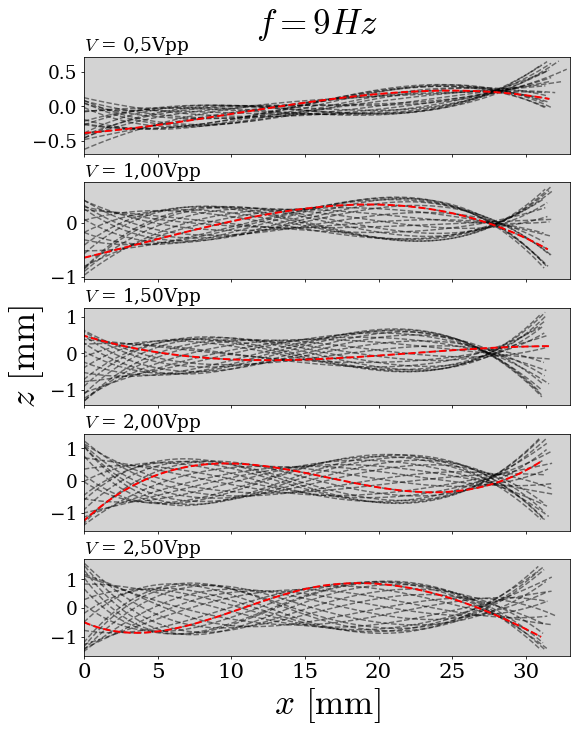

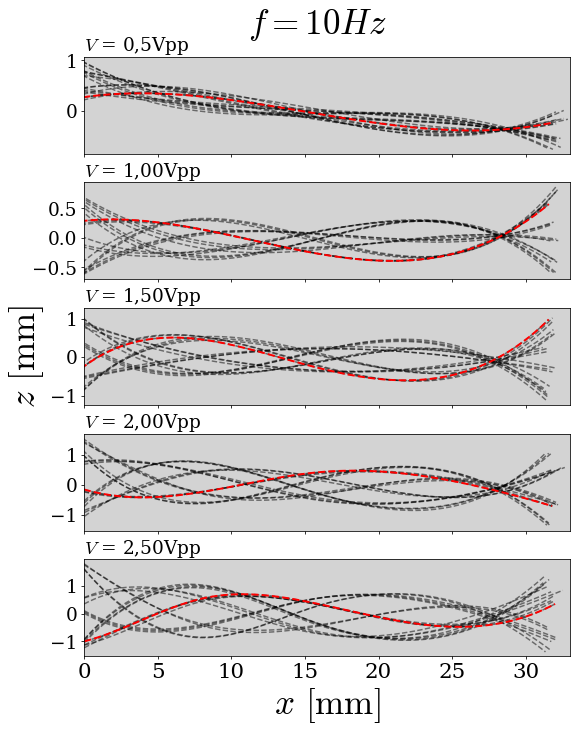

In [12]:
currHz_array = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7,33Hz','7,66Hz','8Hz','9Hz','10Hz'] #We create a frecuency array

index_start = 0

for currHz in currHz_array:
    filtered_namelist = [name for name in npz_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    
    fig, axs = plt.subplots(5,1, figsize=(8,10), sharex=True)

    fig.suptitle(f'$f={currHz}$', fontsize=36)
    fig.tight_layout()
    
    for rotated_tail,filename,ax in zip(rotated_tails,filtered_namelist,axs):
                
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))

        t_tail = np.arange(rotated_tail.shape[0])

        N_PERIODS = int(3*(fval**-1)*FRAME_PER_SECOND)
        MIDPOINT = int(len(rotated_tail)//2)
        ax.set_title(f'$V$ = {v}', loc='left', fontsize=19)
        [ax.plot(tail[0]/PX_PER_MM, tail[1]/PX_PER_MM, color='k', ls='--', alpha=0.5) for tail in rotated_tail[MIDPOINT:MIDPOINT+N_PERIODS]]
        ax.plot(rotated_tail[MIDPOINT+N_PERIODS-1][0]/PX_PER_MM, rotated_tail[MIDPOINT+N_PERIODS-1][1]/PX_PER_MM, color='r', ls='--', lw=2, alpha=1)

        last_xticks = ax.get_xticks()
        last_xticklabels = ax.get_xticklabels()
        ax.grid()    
    axs[int(axs.size//2)].set_ylabel(f'$z$ $[\\text{{mm}}]$')
    axs[-1].set_xlabel(f'$x$ $[\\text{{mm}}]$')
    [ax.set_xticklabels([]) for ax in axs[:-1]]
    
    axs[-1].set_xticks(last_xticks)
    axs[-1].set_xticklabels(last_xticklabels)
    [ax.set_xlim(0,33) for ax in axs]

    fig.savefig(f'forma_cola_{currHz}.png')

### Forma de la cola en función de la frecuencia agrupado por voltaje

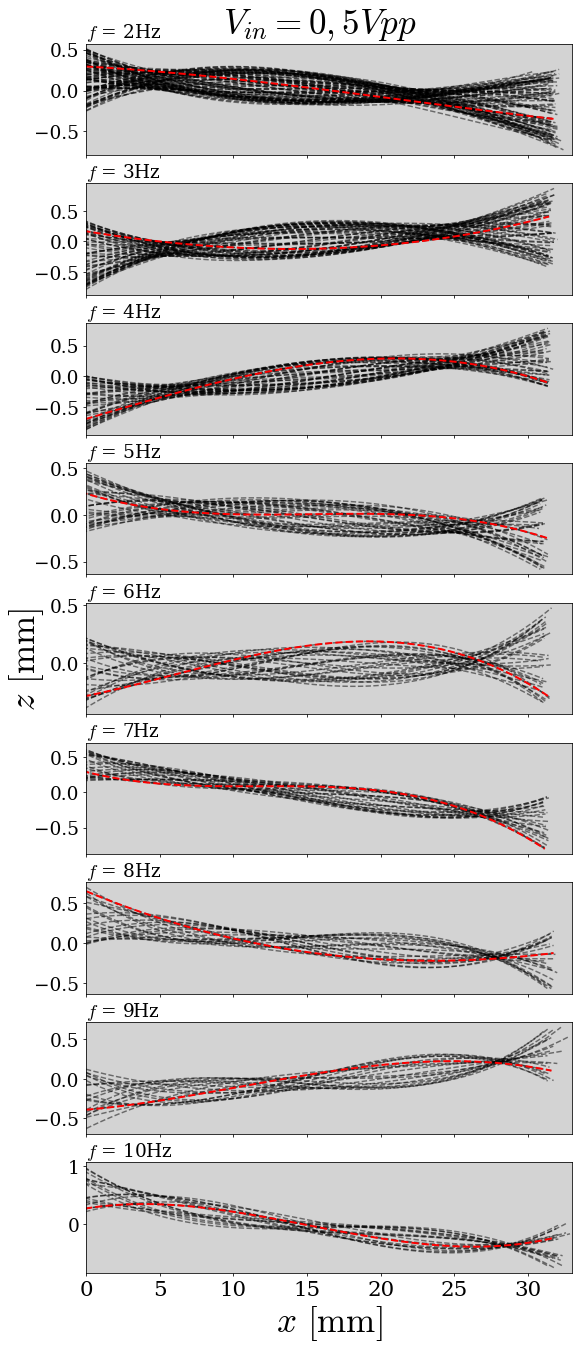

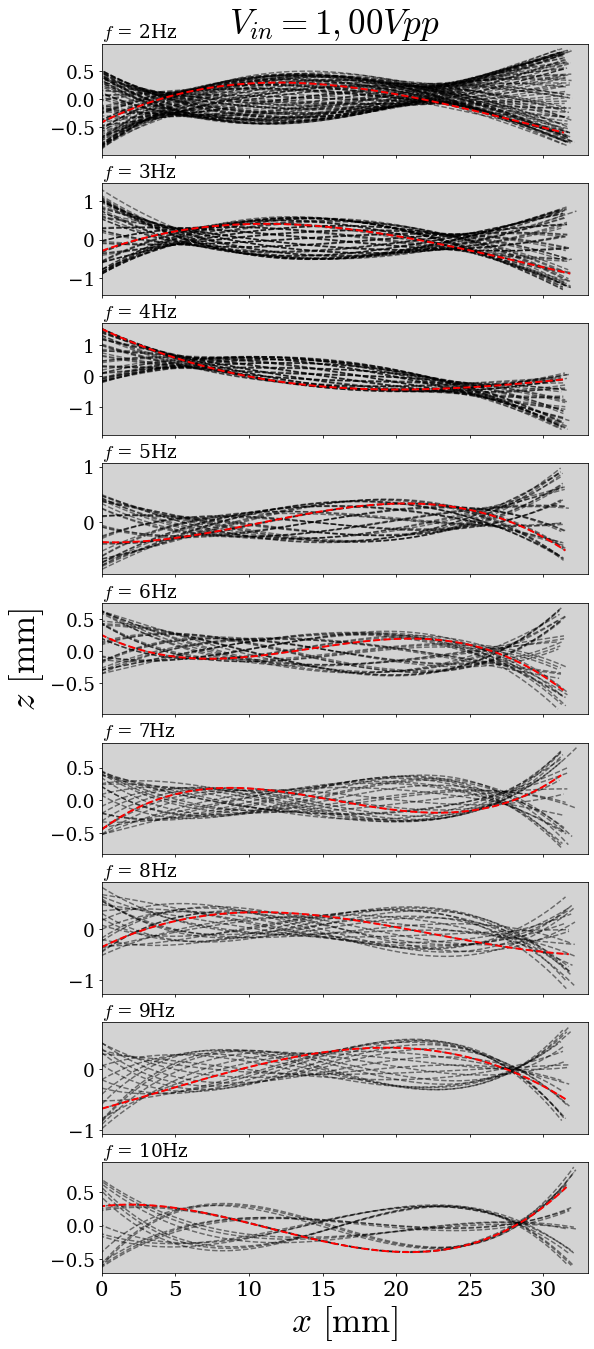

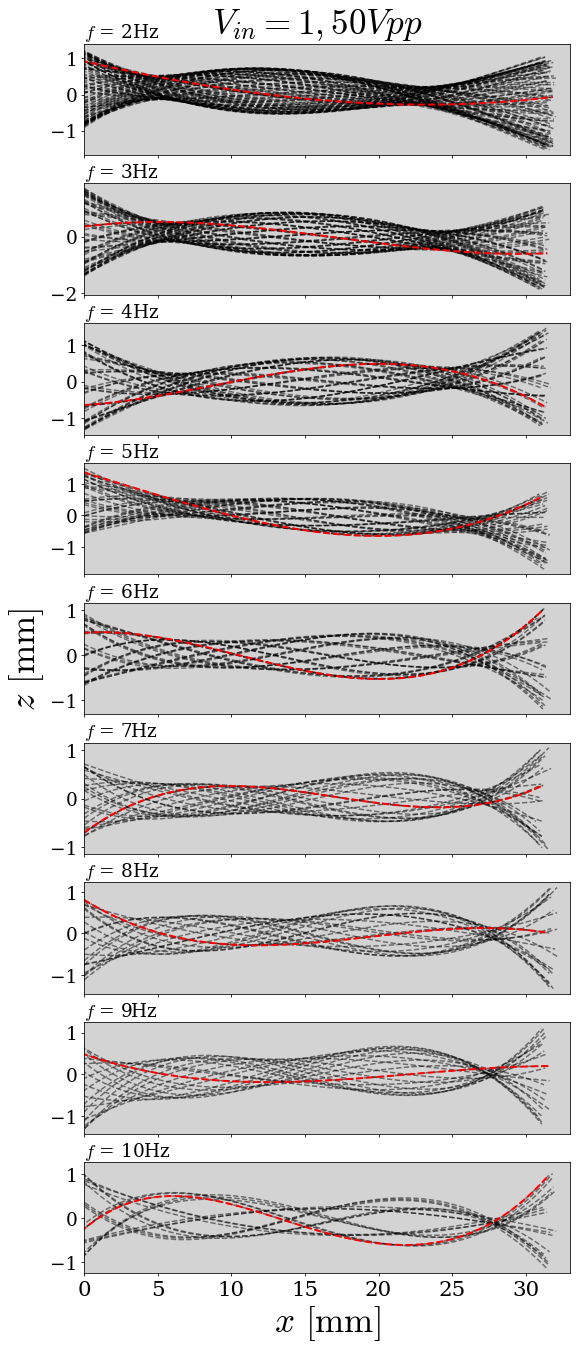

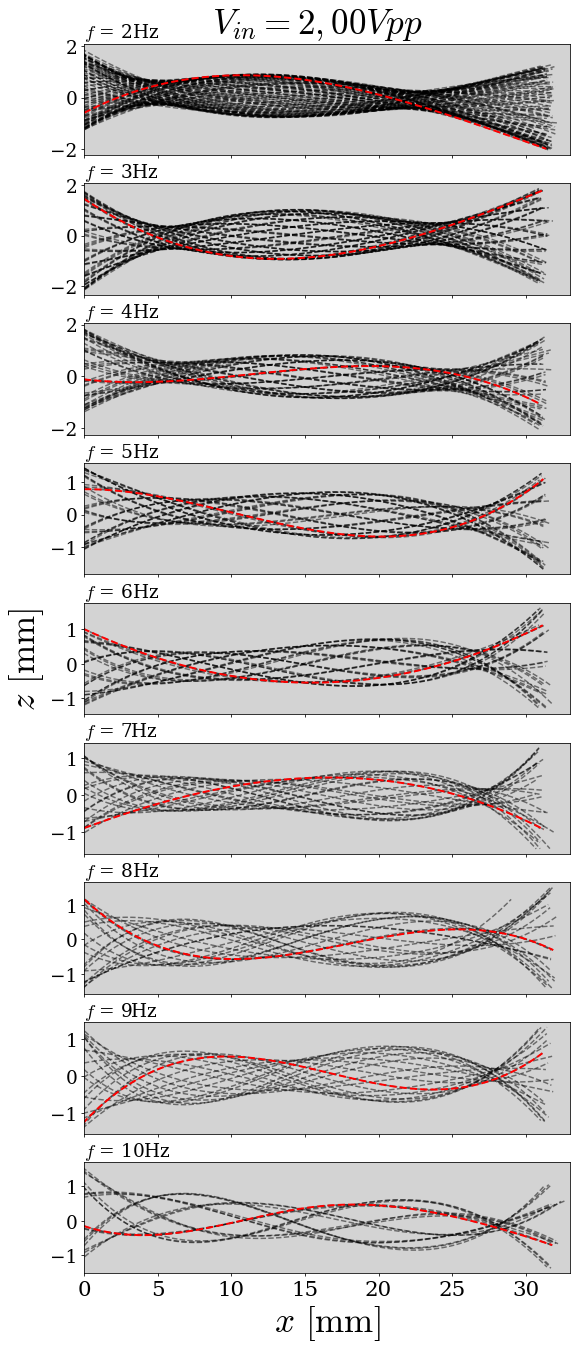

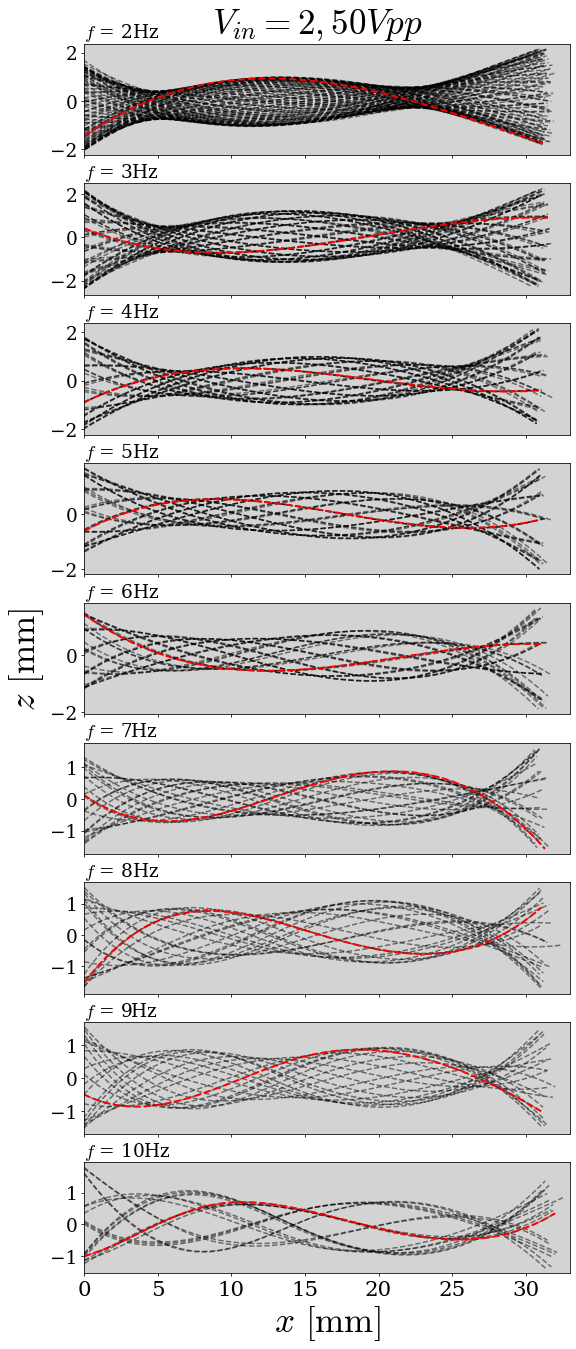

In [20]:
currVolt_array = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

index_start = 0

for currVolt in currVolt_array:
    filtered_namelist = [name for name in natsorted(npz_names) if re.match(r'\b'+currVolt+r'\b',name.split('-')[0]) and '7,33' not in name and '7,66' not in name] #We get the names of those files
    rotated_tails = np.array([np.load(f'ECO20-45mm/forma_cola_rotada/{name}', allow_pickle=True)['arr'] for name in filtered_namelist], dtype=object)
    
    fig, axs = plt.subplots(9,1, figsize=(8,19), sharex=True) # para 5 frecs, 5,1 y figsize=(8,10)

    fig.suptitle(f'$V_{{in}}={currVolt}$', fontsize=36)
    fig.tight_layout()
    
    for rotated_tail,filename,ax in zip(rotated_tails,filtered_namelist,axs):
                
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        if f!='7,33Hz' and f!='7,66Hz':
            vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
            fval = float(f.split('Hz')[0].replace(',','.'))

            t_tail = np.arange(rotated_tail.shape[0])
            # ax.plot(rotated_tail[0,0]/PX_PER_MM, rotated_tail[0,1]/PX_PER_MM, color= 'r', ls='--', alpha=0.5, label=f)
            ax.set_title(f'$f$ = {f}', loc='left', fontsize=19)
            N_PERIODS = int(3*(fval**-1)*FRAME_PER_SECOND)
            MIDPOINT = int(len(rotated_tail)//2)
            [ax.plot(tail[0]/PX_PER_MM, tail[1]/PX_PER_MM, color='k', ls='--', alpha=0.5) for tail in rotated_tail[MIDPOINT:MIDPOINT+N_PERIODS]]
            ax.plot(rotated_tail[MIDPOINT+N_PERIODS-1][0]/PX_PER_MM, rotated_tail[MIDPOINT+N_PERIODS-1][1]/PX_PER_MM, color='r', ls='--', lw=2, alpha=1)

            # ax.legend()
            last_xticks = ax.get_xticks()
            last_xticklabels = ax.get_xticklabels()
            ax.grid()

    axs[int(axs.size//2)].set_ylabel(f'$z$ $[\\text{{mm}}]$')
    axs[-1].set_xlabel(f'$x$ $[\\text{{mm}}]$')
    [ax.set_xticklabels([]) for ax in axs[:-1]]
    
    axs[-1].set_xticks(last_xticks)
    axs[-1].set_xticklabels(last_xticklabels)
    
    [ax.set_xlim(0,33) for ax in axs]

    # fig.savefig(f'forma_cola_{currVolt}.png')